In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import euclidean_distances
import networkx as nx
import datetime

Se carga la tabla de los datos y se formatea la columna de fecha-hora

In [2]:
tabla_datos = pd.read_csv("vehicle_gps.csv")
tabla_datos['timestamp'] = pd.to_datetime(tabla_datos['timestamp'])

Se hace una primera visualización de los nodos para tener una idea general de las distintas calles recorridas

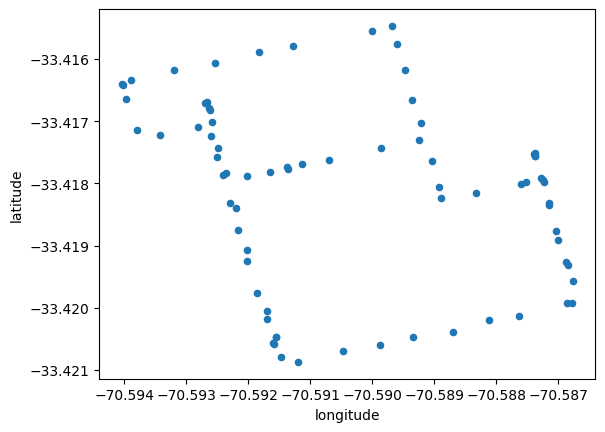

In [24]:
ax = tabla_datos.plot.scatter(x = 'longitude', y = 'latitude')
x_lim = ax.get_xlim()
y_lim = ax.get_ylim()
plt.show()

Se puede notar que hay 9 calles en total

Ya que los datos están estructurados de manera que, para cada vehículo, las entradas consecutivas corresponden a lecturas consecutivas del viaje, se asume que cada nodo está conectado con el inmediatamente siguiente. Además, se calcula la velocidad promedio a la que recorre cada nodo,

In [4]:
#Se obtienen los nodos que pertenecen al mismo viaje

tabla_datos['sig_vehiculo'] = tabla_datos.vehicle.shift(-1).fillna(0)
tabla_datos['tiene_nodo_sig'] = (tabla_datos['vehicle'] == tabla_datos['sig_vehiculo'])
tabla_datos['vecinos'] = tabla_datos.apply(lambda x: [x.name + 1] if x['tiene_nodo_sig'] else [], axis = 1)

#Se obtienen los datos del siguiente nodo

tabla_datos['latitud_sig'] = tabla_datos.latitude.shift(-1).fillna(0)
tabla_datos['longitud_sig'] = tabla_datos.longitude.shift(-1).fillna(0)
tabla_datos['tiempo_sig'] = tabla_datos.timestamp.shift(-1).fillna(0)
tabla_datos['tiempo_sig'] = pd.to_datetime(tabla_datos['tiempo_sig'])

#Se calcula tanto el delta espacial como el delta temporal

tabla_datos['delta'] = np.linalg.norm(tabla_datos.loc[:, ['longitude', 'latitude']].values
                                    - tabla_datos.loc[:, ['longitud_sig', 'latitud_sig']].values, axis=1)
tabla_datos['delta_t'] = tabla_datos.apply(lambda x: (x['tiempo_sig'] - x['timestamp']) /
                                                            pd.Timedelta(minutes=1), axis = 1)

tabla_datos['velocidad'] = tabla_datos['delta'] /  tabla_datos['delta_t']

#Se calcula la velocidad promedio, considerando solamente los viajes 'válidos'

velocidad_promedio = np.ma.masked_invalid(tabla_datos[(tabla_datos['tiene_nodo_sig'])]['velocidad']).mean()

Se eliminan los datos que no serán reutilizados

In [5]:
col_x_eliminar = ['sig_vehiculo','tiene_nodo_sig', 'latitud_sig', 'longitud_sig', 'delta', 'delta_t', 'velocidad']
tabla_datos.drop(col_x_eliminar, axis = 1, inplace = True)

Para poder unir los 'subgrafos' generados a partir de cada ruta trazada, se propone considerar que los nodos 'suficientemente cercanos' están conectados

In [6]:
#Se formatean los nodos para poder calcular la distancia eficientemente

nodos = (tabla_datos[['longitude', 'latitude']]).to_numpy()
dist = euclidean_distances(nodos, nodos)
radio = 5e-4

#Se buscan los nodos cercanos, evitando encontrar los mismos

nodos_cercanos_bool = ((dist > 0) & (dist < radio))
nodos_cercanos = [fila.nonzero()[0] for fila in nodos_cercanos_bool]

Los nodos cercanos quedan conectados

In [7]:
tabla_datos['vecinos'] = tabla_datos.apply(
                            lambda x:np.concatenate((x['vecinos'], nodos_cercanos[x.name])),
                            axis = 1)

Se calcula la distancia a los nodos a los cuales está conectado para poder asignarles el peso en el grafo

In [8]:
distancia_vecinos = []
for indice, filas in tabla_datos.iterrows():

    nodos_vecinos = tabla_datos.iloc[filas['vecinos']]
    distancia = euclidean_distances([filas[['longitude', 'latitude']]],
                                (nodos_vecinos[['longitude', 'latitude']]).to_numpy())
    
    distancia_vecinos.append(distancia[0])

tabla_datos['distancia_vecinos'] = distancia_vecinos

A partir de la tabla de datos, teniendo la posición de los nodos y los vertices vecinos, se construye el grafo. Este se asume bidireccional, y con los mismos pesos en cada arista

In [9]:
grafo = nx.Graph()

pos = {}

for indice_origen, fila in tabla_datos.iterrows():

    pos[indice_origen] = (fila['longitude'], fila['latitude'])

    for indice_vecino in range(len(fila['vecinos'])):
        grafo.add_edge(indice_origen, fila['vecinos'][indice_vecino],
                       weight = fila['distancia_vecinos'][indice_vecino])

nx.set_node_attributes(grafo, pos, 'pos')

Se muestra una visualización del grafo

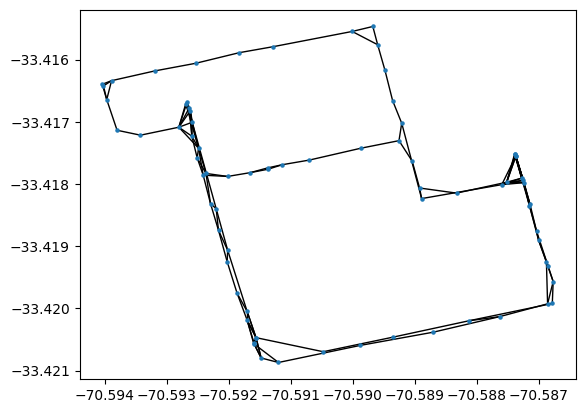

In [10]:
fig, ax = plt.subplots()

nx.draw(grafo, pos, ax = ax, node_size = 5)

limits=plt.axis('on')
ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
ax.set_xlim(x_lim)
ax.set_ylim(y_lim)

plt.show()

Se implementa la función del algoritmo de la ruta mas corta entre dos nodos, que entrega tanto la ruta mas corta (secuencia de nodos recorridos), la distancia recorrida y el tiempo esperado (asumiendo la velocidad antes calculada), además de una visualización de la ruta.

La función recibe dos nodos indexados y una orden de interpretarlo como índice, o dos nodos a partir de su posición y su respectiva orden de recibirlo como coordenadas

In [41]:
def Camino(inicio, llegada, tipo_nodo = 'indice'):

    if tipo_nodo == 'indice':

        camino = nx.shortest_path(grafo, source = inicio, target = llegada, weight='weight')
        distancia = nx.shortest_path_length(grafo, source = inicio, target = llegada, weight='weight')
    
    elif tipo_nodo == 'coordenadas':

        reverse_pos = {v:k for k,v in pos.items() if v in (inicio, llegada)}

        inicio_indice = reverse_pos[inicio]
        llegada_indice = reverse_pos[llegada]

        camino = nx.shortest_path(grafo, source = inicio_indice, target = llegada_indice, weight='weight')
        distancia = nx.shortest_path_length(grafo, source = inicio_indice, target = llegada_indice, weight='weight')

    fig, ax = plt.subplots()
    nx.draw(grafo, pos, ax = ax, node_size = 5)
    limits=plt.axis('on')

    camino_vertices = list(zip(camino, camino[1:]))
    nx.draw_networkx_nodes(grafo,pos,nodelist=camino,node_color='r', node_size=5, ax = ax)
    nx.draw_networkx_edges(grafo,pos,edgelist=camino_vertices,edge_color='r', ax = ax)

    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
    ax.set_xlim(x_lim)
    ax.set_ylim(y_lim)

    plt.show()

    tiempo = distancia/velocidad_promedio
    tiempo_formato = str(datetime.timedelta(minutes=distancia/velocidad_promedio))

    print(f'La ruta entre los nodos {inicio} y {llegada} es a través de:')
    print("".join([f"Nodo {nodo}, ubicado en {pos[nodo]}\n" for nodo in camino]))
    print(f'Con una longitud de {distancia} unidades')
    print(f'y un tiempo esperado de {tiempo_formato}')
    
    return camino, distancia, tiempo

Se realiza una prueba de la función

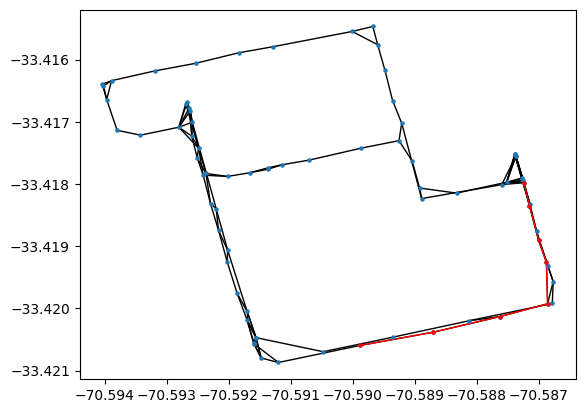

La ruta entre los nodos 68 y 53 es a través de:
Nodo 68, ubicado en (-70.589875, -33.420594)
Nodo 69, ubicado en (-70.588705, -33.420383)
Nodo 70, ubicado en (-70.587629, -33.420132)
Nodo 71, ubicado en (-70.586857, -33.419926)
Nodo 72, ubicado en (-70.586876, -33.419257)
Nodo 73, ubicado en (-70.587003, -33.418902)
Nodo 74, ubicado en (-70.587149, -33.41835)
Nodo 53, ubicado en (-70.587237, -33.417979)

Con una longitud de 0.005091356446790728 unidades
y un tiempo esperado de 0:11:04.953069


In [42]:
inicio = np.random.randint(0, len(pos))
llegada = np.random.randint(0, len(pos))

camino, distancia, tiempo = Camino(inicio, llegada)